<a href="https://colab.research.google.com/github/Sriyoshija/task7/blob/main/Task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear SVM CV Accuracy: 0.86 (±0.03)
RBF SVM CV Accuracy: 0.86 (±0.03)

Best parameters from tuning: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Linear SVM Test Accuracy: 0.91
Initial RBF SVM Test Accuracy: 0.89
Tuned RBF SVM Test Accuracy: 0.91


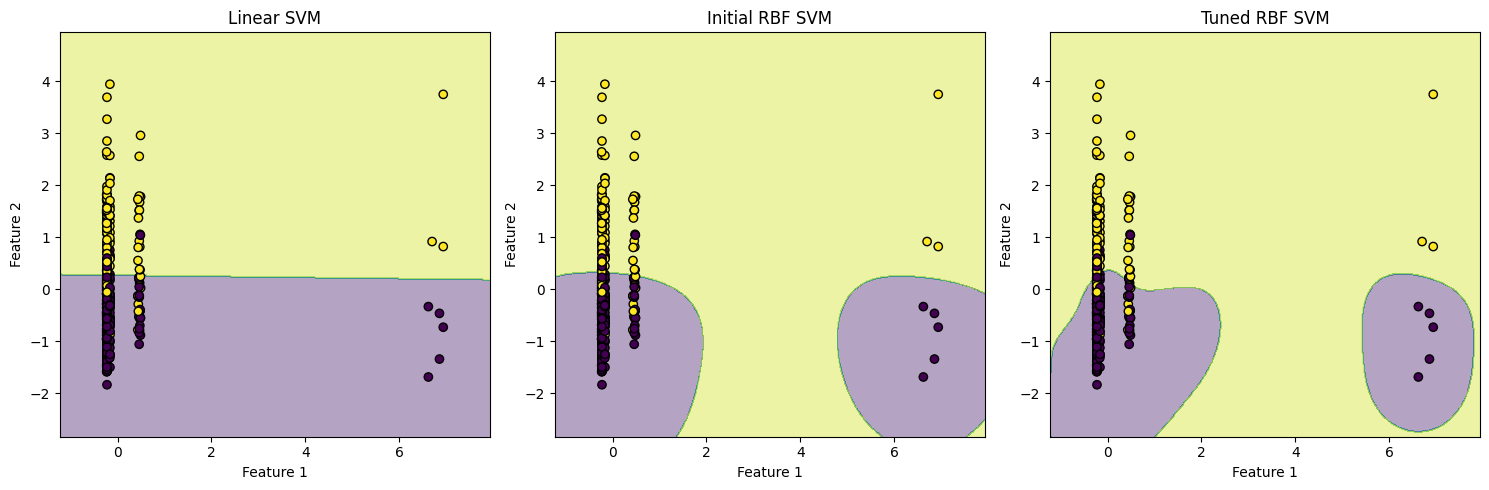

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

csv_path = "/content/breast-cancer.csv"

def load_and_prepare_data(path):
    df = pd.read_csv(path)

    if 'diagnosis' in df.columns:
        X = df.drop('diagnosis', axis=1)
        y = df['diagnosis']
    else:
        raise ValueError("Target column 'diagnosis' not found in the dataset.")

    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    X = X.dropna(axis=1, how='all')
    initial_rows = X.index
    X = X.dropna()
    remaining_rows = X.index
    y = y[remaining_rows]
    le = LabelEncoder()
    y = le.fit_transform(y)

    if X.empty:
        raise ValueError("No data remaining after handling missing values.")
    if X.shape[1] >= 2:
        X = X.values[:, :2]
    else:
        raise ValueError("Not enough numeric features remaining after preprocessing.")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    if X_train.shape[0] == 0:
         raise ValueError("The training set is empty. Please check data preprocessing and splitting.")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

#Train SVM models
def train_svm_models(X_train, y_train):
    #Linear SVM
    linear_svm = SVC(kernel='linear', C=1.0)
    linear_svm.fit(X_train, y_train)

    #RBF Kernel SVM
    rbf_svm = SVC(kernel='rbf', gamma='scale', C=1.0)
    rbf_svm.fit(X_train, y_train)
    return linear_svm, rbf_svm

#Visualization function
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

#Hyperparameter tuning
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1, 10],
        'kernel': ['rbf']
    }

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_estimator_

if __name__ == "__main__":
    X_train, X_test, y_train, y_test, scaler = load_and_prepare_data(csv_path)

    #Train initial models
    linear_svm, rbf_svm = train_svm_models(X_train, y_train)

    #Cross-validation evaluation
    linear_scores = cross_val_score(linear_svm, X_train, y_train, cv=5)
    rbf_scores = cross_val_score(rbf_svm, X_train, y_train, cv=5)
    print(f"Linear SVM CV Accuracy: {linear_scores.mean():.2f} (±{linear_scores.std():.2f})")
    print(f"RBF SVM CV Accuracy: {rbf_scores.mean():.2f} (±{rbf_scores.std():.2f})")

    #Hyperparameter tuning
    best_params, best_model = tune_hyperparameters(X_train, y_train)
    print(f"\nBest parameters from tuning: {best_params}")

    #Final evaluation on test set
    for name, model in [('Linear SVM', linear_svm),
                        ('Initial RBF SVM', rbf_svm),
                        ('Tuned RBF SVM', best_model)]:
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Test Accuracy: {acc:.2f}")

    #Visualize decision boundaries
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plot_decision_boundary(linear_svm, X_train, y_train, 'Linear SVM')
    plt.subplot(1, 3, 2)
    plot_decision_boundary(rbf_svm, X_train, y_train, 'Initial RBF SVM')
    plt.subplot(1, 3, 3)
    plot_decision_boundary(best_model, X_train, y_train, 'Tuned RBF SVM')
    plt.tight_layout()
    plt.show()